# GTSRB TinyML Master: Kaggle-to-Car Pipeline
### Goal: Train a 96x96 CNN for traffic sign recognition on ESP32-CAM

This notebook handles:
1. **Surgical Data Prep**: Filtering exactly 5 classes (Stop, Slow, Return, Left, Right).
2. **ROI Cropping**: Using bounding boxes to ensure the sign fills the frame.
3. **Dual-Stream Augmentation**: Training on both Color and High-Contrast Grayscale.
4. **INT8 Quantization**: Squeezing the model for microcontroller deployment.
5. **C Export**: Generating `model_data.h` automatically.

In [6]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


BASE_PATH = "/kaggle/input/gtsrb-german-traffic-sign"
TRAIN_CSV = f"{BASE_PATH}/Train.csv"
OUTPUT_DIR = "processed_gtsrb_dataset"
TARGET_SIZE = (96, 96)
BATCH_SIZE = 32
SEED = 123


TARGET_CLASSES = {
    14: "STOP",
    27: "SLOW",
    40: "RETURN",
    33: "RIGHT",
    34: "LEFT"
}

ID_TO_LABEL = {v: k for k, v in TARGET_CLASSES.items()}

## 1. Data Preparation (Surgical ROI & Augmentation)
We use the bounding boxes to extract only the sign, then create both Normal and Grayscale+Equalized versions for Robustness.

In [7]:
def preprocess_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    eq = cv2.equalizeHist(gray)
    return cv2.cvtColor(eq, cv2.COLOR_GRAY2BGR)

print("Preparing dataset...")
for name in TARGET_CLASSES.values():
    os.makedirs(f"{OUTPUT_DIR}/{name}", exist_ok=True)

df = pd.read_csv(TRAIN_CSV)

for idx, row in tqdm(df.iterrows(), total=len(df)):
    cid = int(row["ClassId"])
    if cid not in TARGET_CLASSES:
        continue

    label = TARGET_CLASSES[cid]
    img_path = os.path.join(BASE_PATH, row["Path"])
    img = cv2.imread(img_path)
    if img is None:
        continue

    x1, y1, x2, y2 = row["Roi.X1"], row["Roi.Y1"], row["Roi.X2"], row["Roi.Y2"]
    crop = img[y1:y2, x1:x2]
    crop = cv2.resize(crop, TARGET_SIZE)

    cv2.imwrite(f"{OUTPUT_DIR}/{label}/{idx}_color.jpg", crop)
    cv2.imwrite(f"{OUTPUT_DIR}/{label}/{idx}_gray.jpg", preprocess_image(crop))

Preparing dataset...


  0%|          | 0/39209 [00:00<?, ?it/s]

## 2. Model Training
We use a lightweight CNN optimized for the ESP32's memory constraints.

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    OUTPUT_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=TARGET_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    OUTPUT_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=TARGET_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 9956 files belonging to 5 classes.
Using 7965 files for training.
Found 9956 files belonging to 5 classes.
Using 1991 files for validation.
Classes: ['LEFT', 'RETURN', 'RIGHT', 'SLOW', 'STOP']


In [9]:
model = keras.Sequential([
    layers.Input(shape=(96, 96, 3)),
    layers.Rescaling(1./255),

    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(len(TARGET_CLASSES), activation="softmax")
])

In [10]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 96, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     1,179,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,185,125 (4.52 MB)

 Trainable params: 1,185,125 (4.52 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=12
)

Epoch 1/12
249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8456 - loss: 0.4112 - val_accuracy: 0.9990 - val_loss: 0.0045
Epoch 2/12
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9984 - loss: 0.0088 - val_accuracy: 1.0000 - val_loss: 9.5738e-04
Epoch 3/12
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9997 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 4/12
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9989 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 1.6627e-04
Epoch 5/12
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 1.0000 - loss: 1.1517e-04 - val_accuracy: 1.0000 - val_loss: 8.0583e-05
Epoch 6/12
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 8.3173e-05 - val_accuracy: 1.0000 - val_loss: 4.9325e-05
Epoch 7/12
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 5.5473e-05 - val_accuracy: 1.0000 - val_loss: 4.0465e-05
Epoch 8/12
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 

## Evaluation on Held-Out Validation Data
Accuracy is expected to be high due to:

1. ROI cropping

2. Controlled class count

3. Highly distinctive symbols

But we still verify rigorously

In [12]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

<Figure size 600x600 with 0 Axes>

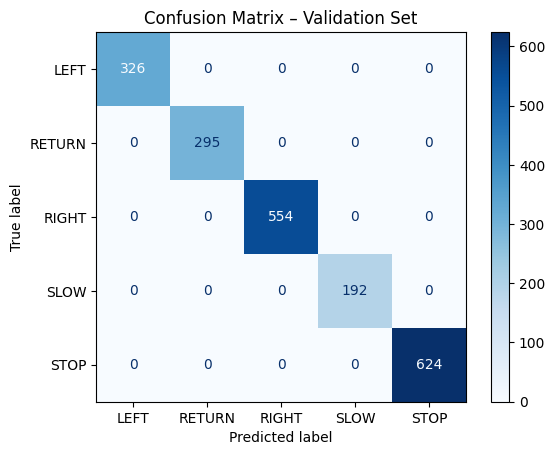

In [13]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)

plt.figure(figsize=(6,6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Validation Set")
plt.show()

## Inference Latency Estimation (Host Side)

Host ≠ ESP32, but this gives a relative baseline

In [14]:
sample_batch = next(iter(val_ds))[0][:1]

# Warm-up
for _ in range(5):
    model(sample_batch)

start = time.time()
for _ in range(100):
    model(sample_batch)
end = time.time()

avg_latency = (end - start) / 100
print(f"Average inference latency (FP32, host): {avg_latency*1000:.2f} ms")

Average inference latency (FP32, host): 6.61 ms


## 3. Quantization (INT8)
This converts the weights to 8-bit integers, making the model 4x smaller and significantly faster.

In [15]:
def representative_data_gen():
    for images, _ in train_ds.take(100):
        yield [images.numpy().astype(np.float32)]

In [16]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp3_hd7o2a/assets


INFO:tensorflow:Assets written to: /tmp/tmp3_hd7o2a/assets


Saved artifact at '/tmp/tmp3_hd7o2a'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='keras_tensor_10')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  140419670443792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140419670445328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140419670444752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140419670446096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140419670445520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140419670446864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140419670446288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140419670447632: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1766784791.750992      47 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1766784791.751016      47 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


In [17]:
with open("traffic_sign_model.tflite", "wb") as f:
    f.write(tflite_model)

print("INT8 model saved.")

INT8 model saved.


## 4. Export to model_data.h

In [18]:
def convert_to_c_array(bin_file, var_name):
    with open(bin_file, "rb") as f:
        data = f.read()

    hex_array = ", ".join(f"0x{b:02x}" for b in data)
    return f"const unsigned char {var_name}[] = {{\n{hex_array}\n}};"

In [19]:
h_content = convert_to_c_array(
    "traffic_sign_model.tflite",
    "g_traffic_sign_model"
)

with open("model_data.h", "w") as f:
    f.write(h_content)

print("model_data.h generated successfully.")

model_data.h generated successfully.
